Ch2. deep learning 기반 시계열 데이터 예측
1. RNN  
2. LSTM  
3. GRU  

1. RNN (Recurrent neural network) 기반 예측 모델 개발

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. 시계열 데이터 생성 (랜덤 + 추세 + 계절성)
np.random.seed(42)
time = np.arange(100)
trend = 0.05 * time  # 선형 추세
seasonality = 2 * np.sin(2 * np.pi * time / 20)  # 주기 20의 계절성
noise = np.random.normal(scale=0.5, size=100)  # 랜덤 노이즈
data = trend + seasonality + noise  # 최종 데이터

# 2. 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# 3. 데이터셋 생성 함수
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)


seq_length = 10  # RNN 입력 시퀀스 길이, time_steps과 동일한 의미
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
print(X_train.shape, y_train.shape)
print(y_train[:2])
print(X_train[:1])
print(data_scaled[:12])



torch.Size([90, 10, 1]) torch.Size([90, 1])
tensor([[0.2674],
        [0.2022]])
tensor([[[0.2651],
         [0.3053],
         [0.4200],
         [0.5266],
         [0.4642],
         [0.4811],
         [0.5796],
         [0.5062],
         [0.3903],
         [0.3902]]])
[[0.26511081]
 [0.30529068]
 [0.41997072]
 [0.52658386]
 [0.46417115]
 [0.48112308]
 [0.57955842]
 [0.50620448]
 [0.39033179]
 [0.39015765]
 [0.26739568]
 [0.20215441]]


In [38]:
# 4. RNN 모델 정의
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # hidden vector의 차원 : layer 수, 배치 사이즈, hidden state의 크기 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, hidden = self.rnn(x, h0)
        # out vector의 차원 : 배치 사이즈, time step, hidden state의 크기
        out = self.fc(hidden[0, :, :])
        # output vector의 제일 끝의 hidden state만 선택하면 hidden과 동일함.
        #out = self.fc(out[:, -1, :])
        return out

# 5. 모델 학습
model = RNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    #print(outputs.shape, y_train.shape)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/200], Loss: 0.0313
Epoch [20/200], Loss: 0.0153
Epoch [30/200], Loss: 0.0166
Epoch [40/200], Loss: 0.0083
Epoch [50/200], Loss: 0.0067
Epoch [60/200], Loss: 0.0059
Epoch [70/200], Loss: 0.0057
Epoch [80/200], Loss: 0.0056
Epoch [90/200], Loss: 0.0055
Epoch [100/200], Loss: 0.0054
Epoch [110/200], Loss: 0.0054
Epoch [120/200], Loss: 0.0053
Epoch [130/200], Loss: 0.0053
Epoch [140/200], Loss: 0.0052
Epoch [150/200], Loss: 0.0052
Epoch [160/200], Loss: 0.0052
Epoch [170/200], Loss: 0.0051
Epoch [180/200], Loss: 0.0051
Epoch [190/200], Loss: 0.0051
Epoch [200/200], Loss: 0.0051


torch.Size([1, 10, 1]) tensor([[[0.8470],
         [0.7580],
         [0.7428],
         [0.5889],
         [0.5654],
         [0.5349],
         [0.4680],
         [0.5858],
         [0.6221],
         [0.6638]]])
Prediction:  [[0.7306144]]
Prediction:  [[0.80227005]]
Prediction:  [[0.8720814]]
Prediction:  [[0.91824055]]
Prediction:  [[0.93431234]]
Prediction:  [[0.91832805]]
Prediction:  [[0.8969507]]
Prediction:  [[0.8717387]]
Prediction:  [[0.82144237]]
Prediction:  [[0.7634069]]


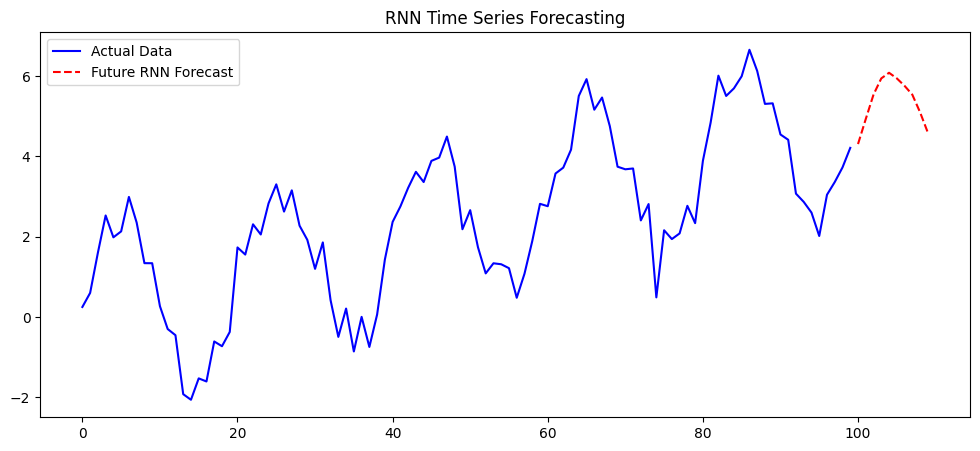

In [39]:
# 6. 미래 데이터 예측 (마지막 시퀀스를 기반으로 10개 예측)
future_steps = 10
last_sequence = torch.tensor(X[-1:], dtype=torch.float32)
print(last_sequence.shape, last_sequence)
future_predictions = []
model.eval()
with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_sequence).numpy()
        print("Prediction: ", next_pred)
        future_predictions.append(next_pred[0][0])
        # Last_sequence의 shape : (Batch size, Time step, Input size)
        # --> shape 변경 : (Time step)
        last_sequence = last_sequence.numpy().reshape(-1)
        # last sequence의 제일 처음 데이터를 제외 하고, pred 값을 마지막에 추가하고, 
        # 해당 sequence가 다음 입력이 될 수 있도록 (Batch size, Time step, Input Size) 로 변경
        last_sequence = last_sequence[1:]
        last_sequence = np.append(last_sequence, next_pred[0][0]).reshape(1, seq_length, 1)
        last_sequence = torch.tensor(last_sequence, dtype=torch.float32)

# 7. 예측값 역변환
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 8. 시각화
plt.figure(figsize=(12, 5))
plt.plot(range(len(data)), data, label='Actual Data', color='blue')
plt.plot(range(len(data), len(data) + future_steps), future_predictions, label='Future RNN Forecast', color='red', linestyle='dashed')
plt.legend()
plt.title('RNN Time Series Forecasting')
plt.show()

- 깊은 RNN 구현 : Layer의 갯수가 2 이상인 경우 RNN 클래스 정의 방법법

In [4]:
# 4. RNN 모델 정의
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # hidden vector의 차원 : layer 수, 배치 사이즈, hidden state의 크기 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        # out vector의 차원 : 배치 사이즈, time step, hidden state의 크기
        # hidden layer의 최상단의 layer의 hidden state의 값을 이용해서 예측.
        # 모든 time step에서의 hidden state을 활용하기도 하고 모든 layer에서의 hidden state을 활용하기도함.
        out = self.fc(out[:, -1, :])
        return out

Epoch [10/200], Loss: 0.0511
Epoch [20/200], Loss: 0.0421
Epoch [30/200], Loss: 0.0218
Epoch [40/200], Loss: 0.0119
Epoch [50/200], Loss: 0.0071
Epoch [60/200], Loss: 0.0065
Epoch [70/200], Loss: 0.0061
Epoch [80/200], Loss: 0.0059
Epoch [90/200], Loss: 0.0057
Epoch [100/200], Loss: 0.0056
Epoch [110/200], Loss: 0.0054
Epoch [120/200], Loss: 0.0053
Epoch [130/200], Loss: 0.0052
Epoch [140/200], Loss: 0.0052
Epoch [150/200], Loss: 0.0051
Epoch [160/200], Loss: 0.0050
Epoch [170/200], Loss: 0.0050
Epoch [180/200], Loss: 0.0050
Epoch [190/200], Loss: 0.0050
Epoch [200/200], Loss: 0.0050


차분 (diff) 적용을 통해 비정상 시계열 데이터를 정상(stationary) 데이터로 변환 후 RNN 적용

Epoch [10/500], Loss: 0.0469
Epoch [20/500], Loss: 0.0346
Epoch [30/500], Loss: 0.0319
Epoch [40/500], Loss: 0.0308
Epoch [50/500], Loss: 0.0292
Epoch [60/500], Loss: 0.0277
Epoch [70/500], Loss: 0.0271
Epoch [80/500], Loss: 0.0264
Epoch [90/500], Loss: 0.0255
Epoch [100/500], Loss: 0.0243
Epoch [110/500], Loss: 0.0214
Epoch [120/500], Loss: 0.0386
Epoch [130/500], Loss: 0.0306
Epoch [140/500], Loss: 0.0301
Epoch [150/500], Loss: 0.0289
Epoch [160/500], Loss: 0.0266
Epoch [170/500], Loss: 0.0257
Epoch [180/500], Loss: 0.0250
Epoch [190/500], Loss: 0.0246
Epoch [200/500], Loss: 0.0241
Epoch [210/500], Loss: 0.0233
Epoch [220/500], Loss: 0.0215
Epoch [230/500], Loss: 0.1792
Epoch [240/500], Loss: 0.0322
Epoch [250/500], Loss: 0.0295
Epoch [260/500], Loss: 0.0283
Epoch [270/500], Loss: 0.0265
Epoch [280/500], Loss: 0.0250
Epoch [290/500], Loss: 0.0242
Epoch [300/500], Loss: 0.0234
Epoch [310/500], Loss: 0.0234
Epoch [320/500], Loss: 0.0214
Epoch [330/500], Loss: 0.0191
Epoch [340/500], Lo

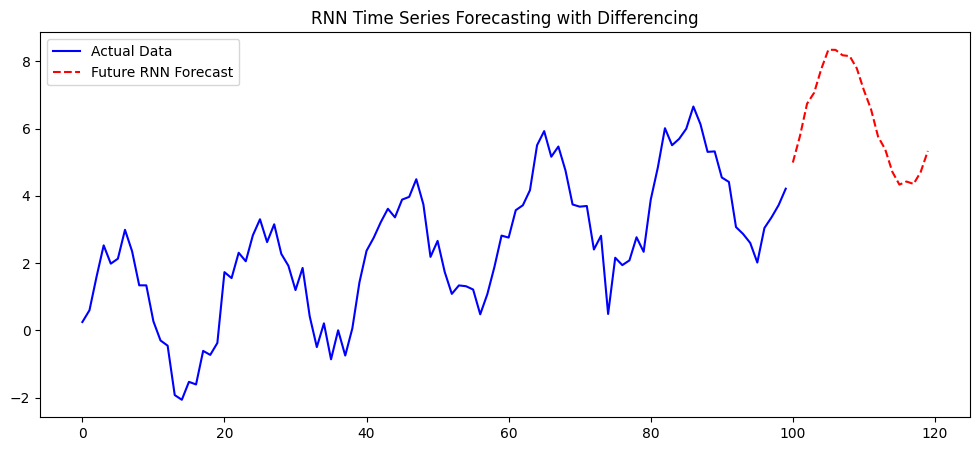

In [40]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. 시계열 데이터 생성 (랜덤 + 추세 + 계절성)
np.random.seed(42)
time = np.arange(100)
trend = 0.05 * time  # 선형 추세
seasonality = 2 * np.sin(2 * np.pi * time / 20)  # 주기 20의 계절성
noise = np.random.normal(scale=0.5, size=100)  # 랜덤 노이즈
data = trend + seasonality + noise  # 최종 데이터

# 2. 1차 차분 적용
differenced_data = np.diff(data)
#print(differenced_data)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(differenced_data.reshape(-1, 1))

# 3. 데이터셋 생성 함수
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10  # RNN 입력 시퀀스 길이
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 4. RNN 모델 정의
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 5. 모델 학습
model = RNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 6. 미래 데이터 예측 (마지막 시퀀스를 기반으로 10개 예측)
future_steps = 20
last_sequence = torch.tensor(X[-1:], dtype=torch.float32)
future_predictions = []

with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_sequence).numpy()
        print("Prediction: ", next_pred)
        future_predictions.append(next_pred[0][0])
        last_sequence = last_sequence.numpy().reshape(-1)
        last_sequence = last_sequence[1:]
        last_sequence = np.append(last_sequence, next_pred[0][0]).reshape(1, seq_length, 1)
        last_sequence = torch.tensor(last_sequence, dtype=torch.float32)

# 7. 예측값 역변환 (차분 되돌리기)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
print(future_predictions)
future_predictions = np.cumsum(future_predictions) + data[-1]  # 차분 복원
print(future_predictions)

# 8. 시각화
plt.figure(figsize=(12, 5))
plt.plot(range(len(data)), data, label='Actual Data', color='blue')
plt.plot(range(len(data), len(data) + future_steps), future_predictions, label='Future RNN Forecast', color='red', linestyle='dashed')
plt.legend()
plt.title('RNN Time Series Forecasting with Differencing')
plt.show()

LSTM 기반 예측 모델  

Epoch [10/500], Loss: 0.0556
Epoch [20/500], Loss: 0.0358
Epoch [30/500], Loss: 0.0267
Epoch [40/500], Loss: 0.0164
Epoch [50/500], Loss: 0.0094
Epoch [60/500], Loss: 0.0072
Epoch [70/500], Loss: 0.0064
Epoch [80/500], Loss: 0.0062
Epoch [90/500], Loss: 0.0060
Epoch [100/500], Loss: 0.0058
Epoch [110/500], Loss: 0.0073
Epoch [120/500], Loss: 0.0057
Epoch [130/500], Loss: 0.0056
Epoch [140/500], Loss: 0.0055
Epoch [150/500], Loss: 0.0053
Epoch [160/500], Loss: 0.0053
Epoch [170/500], Loss: 0.0055
Epoch [180/500], Loss: 0.0055
Epoch [190/500], Loss: 0.0053
Epoch [200/500], Loss: 0.0051
Epoch [210/500], Loss: 0.0049
Epoch [220/500], Loss: 0.0047
Epoch [230/500], Loss: 0.0045
Epoch [240/500], Loss: 0.0043
Epoch [250/500], Loss: 0.0055
Epoch [260/500], Loss: 0.0042
Epoch [270/500], Loss: 0.0040
Epoch [280/500], Loss: 0.0037
Epoch [290/500], Loss: 0.0034
Epoch [300/500], Loss: 0.0034
Epoch [310/500], Loss: 0.0036
Epoch [320/500], Loss: 0.0031
Epoch [330/500], Loss: 0.0031
Epoch [340/500], Lo

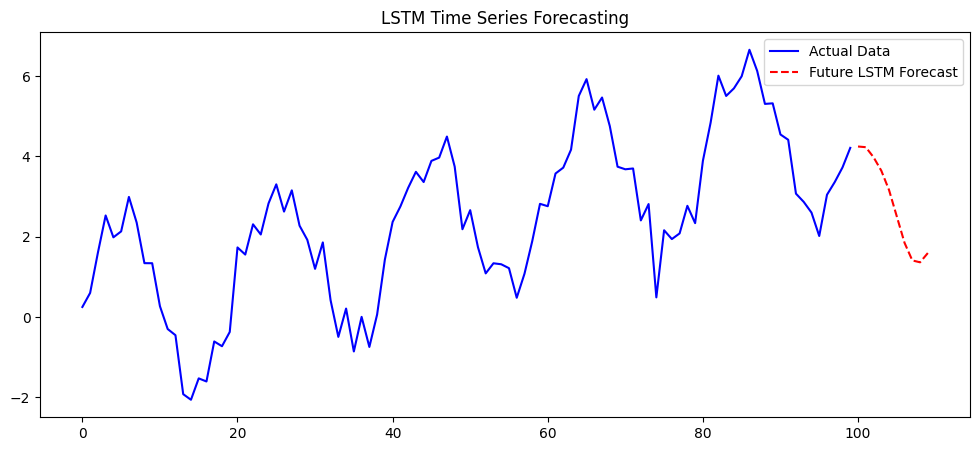

In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. 시계열 데이터 생성 (랜덤 + 추세 + 계절성)
np.random.seed(42)
time = np.arange(100)
trend = 0.05 * time  # 선형 추세
seasonality = 2 * np.sin(2 * np.pi * time / 20)  # 주기 20의 계절성
noise = np.random.normal(scale=0.5, size=100)  # 랜덤 노이즈
data = trend + seasonality + noise  # 최종 데이터

# 2. 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# 3. 데이터셋 생성 함수
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)


seq_length = 10  # RNN 입력 시퀀스 길이, time_steps과 동일한 의미
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# 4. LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size, self.num_layers = hidden_size, num_layers         
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)    
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 5. 모델 학습
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 6. 미래 데이터 예측 (마지막 시퀀스를 기반으로 10개 예측)
future_steps = 10
last_sequence = torch.tensor(X[-1:], dtype=torch.float32)
future_predictions = []

with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_sequence).numpy()
        future_predictions.append(next_pred[0][0])
        next_input = np.append(last_sequence.numpy()[0][1:], next_pred).reshape(1, seq_length, 1)
        last_sequence = torch.tensor(next_input, dtype=torch.float32)

# 7. 예측값 역변환
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 8. 시각화
plt.figure(figsize=(12, 5))
plt.plot(range(len(data)), data, label='Actual Data', color='blue')
plt.plot(range(len(data), len(data) + future_steps), future_predictions, label='Future LSTM Forecast', color='red', linestyle='dashed')
plt.legend()
plt.title('LSTM Time Series Forecasting')
plt.show()

실습 2-1 : 차분 데이터를 이용해서 LSTM 예측 모델을 만드시오

Epoch [10/1000], Loss: 0.0500
Epoch [20/1000], Loss: 0.0362
Epoch [30/1000], Loss: 0.0329
Epoch [40/1000], Loss: 0.0319
Epoch [50/1000], Loss: 0.0316
Epoch [60/1000], Loss: 0.0315
Epoch [70/1000], Loss: 0.0315
Epoch [80/1000], Loss: 0.0313
Epoch [90/1000], Loss: 0.0312
Epoch [100/1000], Loss: 0.0310
Epoch [110/1000], Loss: 0.0307
Epoch [120/1000], Loss: 0.0302
Epoch [130/1000], Loss: 0.0292
Epoch [140/1000], Loss: 0.0252
Epoch [150/1000], Loss: 0.0337
Epoch [160/1000], Loss: 0.0307
Epoch [170/1000], Loss: 0.0303
Epoch [180/1000], Loss: 0.0301
Epoch [190/1000], Loss: 0.0298
Epoch [200/1000], Loss: 0.0296
Epoch [210/1000], Loss: 0.0292
Epoch [220/1000], Loss: 0.0286
Epoch [230/1000], Loss: 0.0276
Epoch [240/1000], Loss: 0.0256
Epoch [250/1000], Loss: 0.0225
Epoch [260/1000], Loss: 0.0216
Epoch [270/1000], Loss: 0.0201
Epoch [280/1000], Loss: 0.0187
Epoch [290/1000], Loss: 0.0177
Epoch [300/1000], Loss: 0.0176
Epoch [310/1000], Loss: 0.0185
Epoch [320/1000], Loss: 0.0181
Epoch [330/1000],

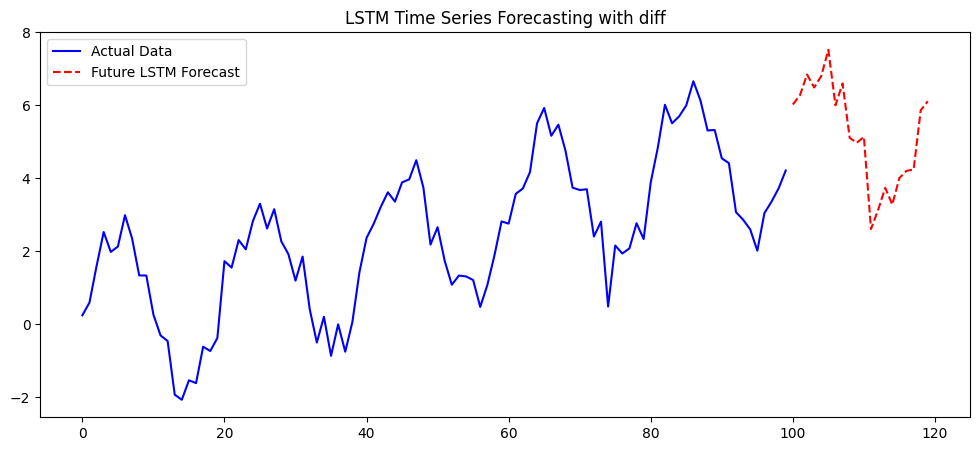

In [41]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 시계열 데이터 생성 (랜덤 + 추세 + 계절성)
np.random.seed(42)
time = np.arange(100)
trend = 0.05 * time  # 선형 추세
seasonality = 2 * np.sin(2 * np.pi * time / 20)  # 주기 20의 계절성
noise = np.random.normal(scale=0.5, size=100)  # 랜덤 노이즈
data = trend + seasonality + noise  # 최종 데이터
################################################
###########        실습2-1-시작        ##########
################################################
# 1. 차분 데이터 셋 만들기 
# (input) data --> (output) X_train, y_train

# 2. LSTM 모델 정의
# class LSTM(nn.Module)
    
    
# 3. 학습
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 4. 예측 및 예측값 역변환 (차분 되돌리기)
# (input) model, data(원본 데이터), 
# (input) scaler (MinMaxScaler), data_diff_scaled (차분 scaled 데이터)
# (output) future predictions





################################################
###########        실습2-1-종료        ##########
################################################

# 5. 시각화
plt.figure(figsize=(12, 5))
plt.plot(range(len(data)), data, label='Actual Data', color='blue')
plt.plot(range(len(data), len(data) + future_steps), future_predictions, label='Future LSTM Forecast', color='red', linestyle='dashed')
plt.legend()
plt.title('LSTM Time Series Forecasting with diff')
plt.show()

GRU를 이용한 예측 모델 개발

Epoch [10/500], Loss: 0.0503
Epoch [20/500], Loss: 0.0323
Epoch [30/500], Loss: 0.0185
Epoch [40/500], Loss: 0.0104
Epoch [50/500], Loss: 0.0083
Epoch [60/500], Loss: 0.0069
Epoch [70/500], Loss: 0.0065
Epoch [80/500], Loss: 0.0064
Epoch [90/500], Loss: 0.0063
Epoch [100/500], Loss: 0.0062
Epoch [110/500], Loss: 0.0062
Epoch [120/500], Loss: 0.0061
Epoch [130/500], Loss: 0.0060
Epoch [140/500], Loss: 0.0059
Epoch [150/500], Loss: 0.0058
Epoch [160/500], Loss: 0.0057
Epoch [170/500], Loss: 0.0056
Epoch [180/500], Loss: 0.0055
Epoch [190/500], Loss: 0.0054
Epoch [200/500], Loss: 0.0054
Epoch [210/500], Loss: 0.0053
Epoch [220/500], Loss: 0.0054
Epoch [230/500], Loss: 0.0053
Epoch [240/500], Loss: 0.0052
Epoch [250/500], Loss: 0.0051
Epoch [260/500], Loss: 0.0051
Epoch [270/500], Loss: 0.0050
Epoch [280/500], Loss: 0.0051
Epoch [290/500], Loss: 0.0051
Epoch [300/500], Loss: 0.0049
Epoch [310/500], Loss: 0.0049
Epoch [320/500], Loss: 0.0048
Epoch [330/500], Loss: 0.0053
Epoch [340/500], Lo

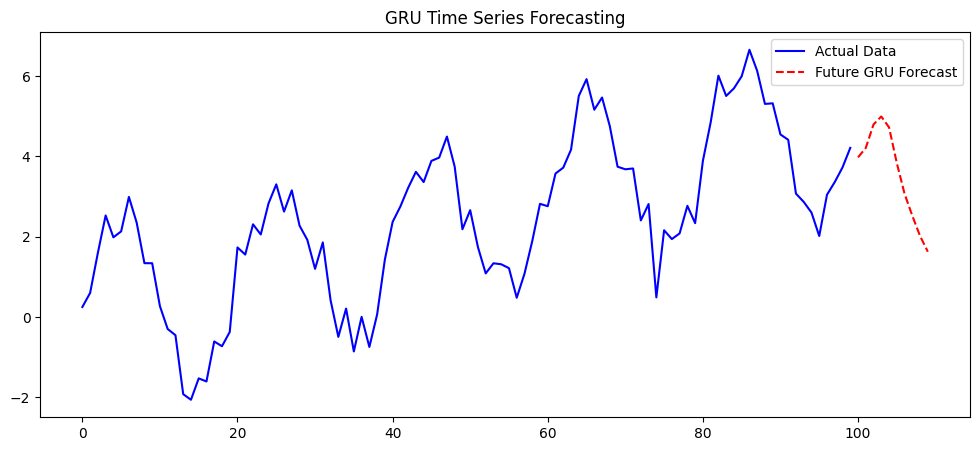

In [42]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. 시계열 데이터 생성 (랜덤 + 추세 + 계절성)
np.random.seed(42)
time = np.arange(100)
trend = 0.05 * time  # 선형 추세
seasonality = 2 * np.sin(2 * np.pi * time / 20)  # 주기 20의 계절성
noise = np.random.normal(scale=0.5, size=100)  # 랜덤 노이즈
data = trend + seasonality + noise  # 최종 데이터

# 2. 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# 3. 데이터셋 생성 함수
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10  # GRU 입력 시퀀스 길이
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 4. GRU 모델 정의
class GRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 5. 모델 학습
model = GRU()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 6. 미래 데이터 예측 (마지막 시퀀스를 기반으로 10개 예측)
future_steps = 10
last_sequence = torch.tensor(X[-1:], dtype=torch.float32)
future_predictions = []

with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_sequence).numpy()
        future_predictions.append(next_pred[0][0])
        next_input = np.append(last_sequence.numpy()[0][1:], next_pred).reshape(1, seq_length, 1)
        last_sequence = torch.tensor(next_input, dtype=torch.float32)

# 7. 예측값 역변환
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_index = pd.date_range(start='2023-04-11', periods=future_steps, freq='D')

# 8. 시각화
plt.figure(figsize=(12, 5))
plt.plot(range(len(data)), data, label='Actual Data', color='blue')
plt.plot(range(len(data), len(data) + future_steps), future_predictions, label='Future GRU Forecast', color='red', linestyle='dashed')
plt.legend()
plt.title('GRU Time Series Forecasting')
plt.show()


### 실습1: APPLE 주식 예측 모델 개발 
2015/01/01 부터 2024/01/01 까지의 데이터로 학습하여,  
2024/01/01 부터 20일 동안의 종가를 예측하는 LSTM 모델을 구축하려고 함.  

input_size = 4 (시가, 고가, 저가, 종가)  
sequence_size (time_steps) = 20 (20일 정보를 바탕으로 다음날 주식을 예측함)  
hidden_size = 50 (cell state, hidden state보다 동일하게 50 크기의 벡터로 함)  


In [105]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

# 1. 애플 주식 데이터 로드
data = pd.read_csv("Data/apple_stock.csv", index_col='Date', parse_dates=True)
data = data[['Open', 'High', 'Low', 'Close']]

# 데이터 학습용(2024-01-01까지) 및 예측 검증용(2024-02-01까지) 분리
train_data = data.loc[:"2024-01-01"]

################################################
###########        실습2-2-시작        ##########
################################################
# 1. 데이터 전 처리
# (input) data
# (ouptut) data_pre




# 2. 데이터셋 생성
# (input) data_pre
# (output) X_train, y_train





# 3. LSTM 모델 정의
# class LSTM (nn.Module)








# 4. 모델 학습
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

################################################
###########        실습2-2-계속        ##########
################################################

torch.Size([2265, 20, 4]) torch.Size([2265, 4])
Epoch [10/500], Loss: 0.0415
Epoch [20/500], Loss: 0.0131
Epoch [30/500], Loss: 0.0018
Epoch [40/500], Loss: 0.0015
Epoch [50/500], Loss: 0.0009
Epoch [60/500], Loss: 0.0005
Epoch [70/500], Loss: 0.0004
Epoch [80/500], Loss: 0.0003
Epoch [90/500], Loss: 0.0003
Epoch [100/500], Loss: 0.0002
Epoch [110/500], Loss: 0.0002
Epoch [120/500], Loss: 0.0002
Epoch [130/500], Loss: 0.0002
Epoch [140/500], Loss: 0.0002
Epoch [150/500], Loss: 0.0002
Epoch [160/500], Loss: 0.0002
Epoch [170/500], Loss: 0.0002
Epoch [180/500], Loss: 0.0002
Epoch [190/500], Loss: 0.0002
Epoch [200/500], Loss: 0.0002
Epoch [210/500], Loss: 0.0002
Epoch [220/500], Loss: 0.0002
Epoch [230/500], Loss: 0.0002
Epoch [240/500], Loss: 0.0002
Epoch [250/500], Loss: 0.0002
Epoch [260/500], Loss: 0.0002
Epoch [270/500], Loss: 0.0002
Epoch [280/500], Loss: 0.0002
Epoch [290/500], Loss: 0.0002
Epoch [300/500], Loss: 0.0002
Epoch [310/500], Loss: 0.0002
Epoch [320/500], Loss: 0.0002
E

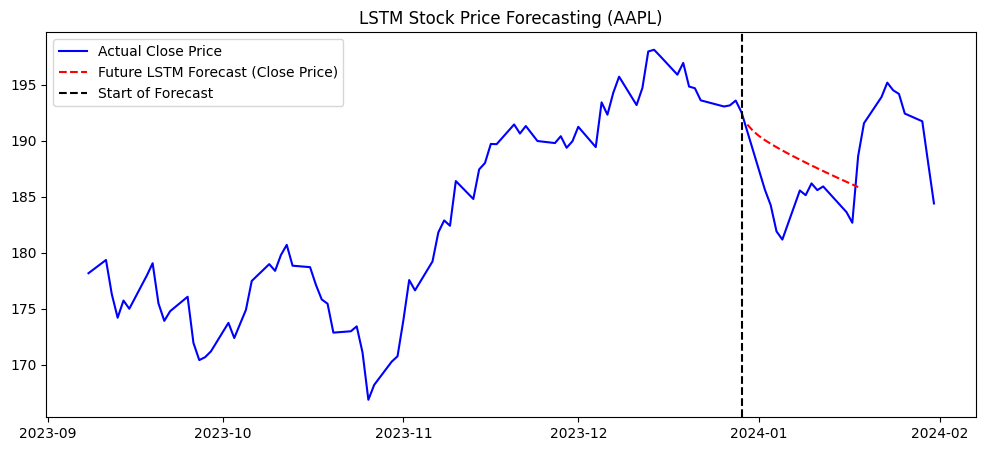

In [106]:
################################################
###########        실습2-2-계속        ##########
################################################
# 5. 미래 데이터 예측 (마지막 시퀀스를 기반으로 10개 예측) 및 . 예측값 역변환
# (input) model, data, 
# (output) future_predictions
future_steps = 20


# 6. 시각화 (실제값과 예측값 비교)
future_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
plt.figure(figsize=(12, 5))
plt.plot(data.index[-100:], data['Close'][-100:], label='Actual Close Price', color='blue')
plt.plot(future_index, future_predictions[:, 3], label='Future LSTM Forecast (Close Price)', color='red', linestyle='dashed')
plt.axvline(train_data.index[-1], color='black', linestyle='--', label='Start of Forecast')
plt.legend()
plt.title('LSTM Stock Price Forecasting (AAPL)')
plt.show()


################################################
###########        실습2-2-종료        ##########
################################################


차분을 이용한 주식 예측

In [101]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

# 1. 애플 주식 데이터 로드
data = pd.read_csv("Data/apple_stock.csv", index_col='Date', parse_dates=True)
data = data[['Open', 'High', 'Low', 'Close']]

# 데이터 학습용(2024-01-01까지) 및 예측 검증용(2024-02-01까지) 분리
train_data = data.loc[:"2024-01-01"]

################################################
###########        실습2-3-시작        ##########
################################################
# 1. 데이터 전 처리
# (input) data
# (ouptut) data_pre






# 2. 데이터셋 생성
# (input) data_pre
# (output) X_train, y_train
seq_length = 20

def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

X, y = create_sequences(data_pre, seq_length)
X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

print(X_train.shape, y_train.shape)




# 3. LSTM 모델 정의
# class LSTM (nn.Module)
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=50, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out



# 4. 모델 학습
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

################################################
###########        실습2-3-계속        ##########
################################################


torch.Size([2264, 20, 4]) torch.Size([2264, 4])
Epoch [10/500], Loss: 0.0497
Epoch [20/500], Loss: 0.0077
Epoch [30/500], Loss: 0.0070
Epoch [40/500], Loss: 0.0069
Epoch [50/500], Loss: 0.0068
Epoch [60/500], Loss: 0.0067
Epoch [70/500], Loss: 0.0067
Epoch [80/500], Loss: 0.0067
Epoch [90/500], Loss: 0.0067
Epoch [100/500], Loss: 0.0067
Epoch [110/500], Loss: 0.0067
Epoch [120/500], Loss: 0.0067
Epoch [130/500], Loss: 0.0067
Epoch [140/500], Loss: 0.0067
Epoch [150/500], Loss: 0.0067
Epoch [160/500], Loss: 0.0067
Epoch [170/500], Loss: 0.0067
Epoch [180/500], Loss: 0.0067
Epoch [190/500], Loss: 0.0067
Epoch [200/500], Loss: 0.0067
Epoch [210/500], Loss: 0.0067
Epoch [220/500], Loss: 0.0067
Epoch [230/500], Loss: 0.0067
Epoch [240/500], Loss: 0.0067
Epoch [250/500], Loss: 0.0067
Epoch [260/500], Loss: 0.0066
Epoch [270/500], Loss: 0.0066
Epoch [280/500], Loss: 0.0066
Epoch [290/500], Loss: 0.0066
Epoch [300/500], Loss: 0.0066
Epoch [310/500], Loss: 0.0066
Epoch [320/500], Loss: 0.0066
E

[[0.46050188 0.4597844  0.4692093  0.46195367]
 [0.54529864 0.5177861  0.524004   0.4740753 ]
 [0.55314714 0.5233745  0.53061134 0.470292  ]
 [0.54470223 0.51700145 0.5249836  0.46940297]
 [0.54023474 0.51374584 0.5218425  0.46954215]
 [0.53974515 0.5135112  0.52148    0.46978018]
 [0.5402358  0.5139619  0.5218262  0.46990198]
 [0.54045975 0.5141707  0.5219927  0.46994355]
 [0.5404258  0.51416695 0.52197504 0.4699622 ]
 [0.5403514  0.51412445 0.52192557 0.46997797]
 [0.5403118  0.5141043  0.52189755 0.46999153]
 [0.54030156 0.51410264 0.52189106 0.4700009 ]
 [0.5403039  0.51410717 0.5218965  0.4700062 ]
 [0.54030234 0.5141082  0.52189666 0.4700095 ]
 [0.54029995 0.5141078  0.5218955  0.47001144]
 [0.5402966  0.5141066  0.52189255 0.47001275]
 [0.540293   0.5141048  0.52188843 0.4700136 ]
 [0.54028976 0.5141031  0.52188456 0.47001413]
 [0.54028636 0.5141012  0.52188015 0.47001448]
 [0.5402835  0.51409954 0.52187645 0.47001472]]
[[-1.9469173  -1.0960251  -0.93901455 -0.11680155]
 [ 0.128

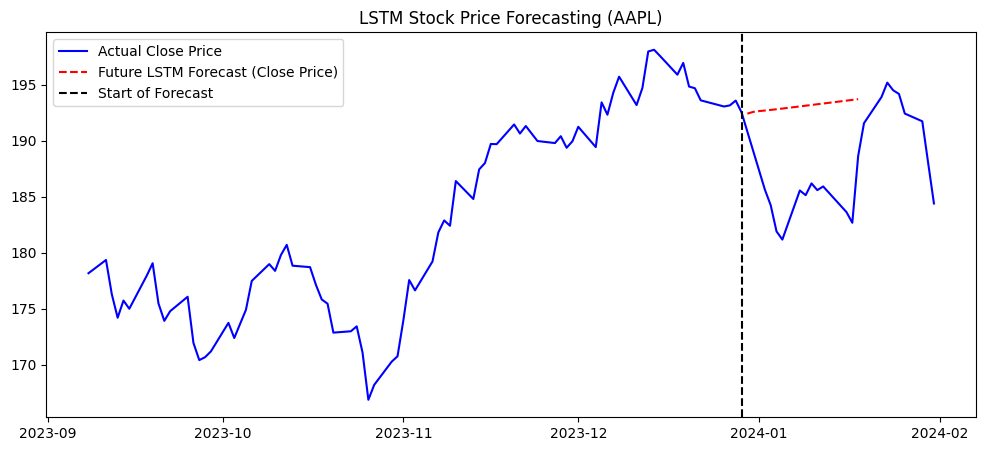

In [102]:
################################################
###########        실습2-3-계속        ##########
################################################

# 5. 미래 데이터 예측 (마지막 시퀀스를 기반으로 10개 예측)
future_steps = 20
last_sequence = torch.tensor(X[-1:], dtype=torch.float32)
future_predictions = []
model.eval()
with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_sequence).numpy()
        future_predictions.append(next_pred[0])
        next_input = np.append(last_sequence.numpy()[0][1:], next_pred).reshape(1, seq_length, 4)
        last_sequence = torch.tensor(next_input, dtype=torch.float32)


# 6. 예측값 역변환 및 원래 데이터 복원







# 7. 시각화 (실제값과 예측값 비교)
plt.figure(figsize=(12, 5))
plt.plot(data.index[-100:], data['Close'][-100:], label='Actual Close Price', color='blue')

plt.plot(future_index, future_predictions[:, 3], label='Future LSTM Forecast (Close Price)', color='red', linestyle='dashed')
plt.axvline(train_data.index[-1], color='black', linestyle='--', label='Start of Forecast')
plt.legend()
plt.title('LSTM Stock Price Forecasting (AAPL)')
plt.show()

################################################
###########        실습2-3-종료        ##########
################################################


LSTM으로 주가를 어떻게 예측할 수 있을까?

Epoch [10/1000], Loss: 0.0232
Epoch [20/1000], Loss: 0.0213
Epoch [30/1000], Loss: 0.0209
Epoch [40/1000], Loss: 0.0205
Epoch [50/1000], Loss: 0.0203
Epoch [60/1000], Loss: 0.0201
Epoch [70/1000], Loss: 0.0200
Epoch [80/1000], Loss: 0.0199
Epoch [90/1000], Loss: 0.0196
Epoch [100/1000], Loss: 0.0193
Epoch [110/1000], Loss: 0.0191
Epoch [120/1000], Loss: 0.0193
Epoch [130/1000], Loss: 0.0188
Epoch [140/1000], Loss: 0.0184
Epoch [150/1000], Loss: 0.0180
Epoch [160/1000], Loss: 0.0178
Epoch [170/1000], Loss: 0.0171
Epoch [180/1000], Loss: 0.0163
Epoch [190/1000], Loss: 0.0154
Epoch [200/1000], Loss: 0.0153
Epoch [210/1000], Loss: 0.0135
Epoch [220/1000], Loss: 0.0120
Epoch [230/1000], Loss: 0.0114
Epoch [240/1000], Loss: 0.0090
Epoch [250/1000], Loss: 0.0078
Epoch [260/1000], Loss: 0.0070
Epoch [270/1000], Loss: 0.0047
Epoch [280/1000], Loss: 0.0038
Epoch [290/1000], Loss: 0.0032
Epoch [300/1000], Loss: 0.0018
Epoch [310/1000], Loss: 0.0011
Epoch [320/1000], Loss: 0.0011
Epoch [330/1000],

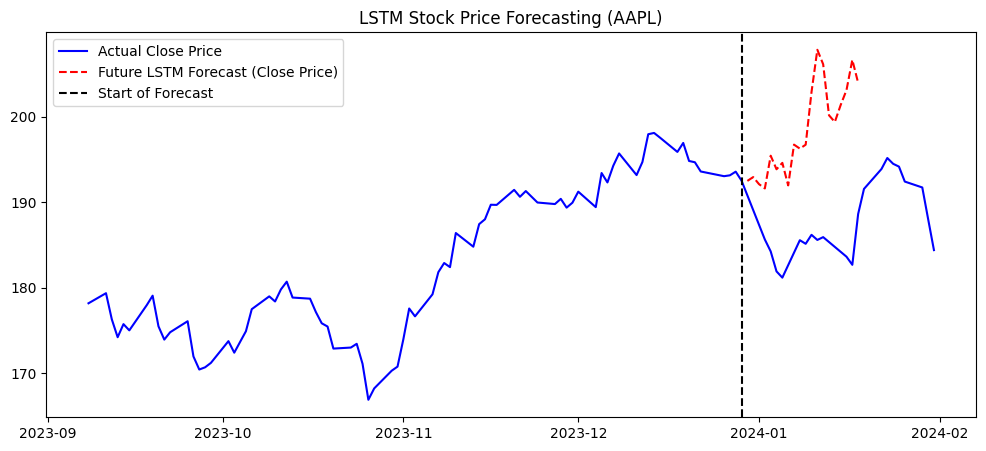

Predicted Future Prices:
                  Open        High         Low       Close        Volume
2023-12-30  192.645352  194.762277  190.816133  192.497775  5.325704e+07
2023-12-31  191.087766  195.472500  189.529378  192.945412  7.613835e+07
2024-01-01  187.726045  193.246843  187.497010  192.116943  7.618923e+07
2024-01-02  188.568066  193.097046  188.379890  191.618444  6.913264e+07
2024-01-03  190.586281  195.373575  191.758715  195.446515  5.227842e+07
2024-01-04  192.011758  194.554989  192.407876  193.860049  3.360652e+07
2024-01-05  192.776888  195.536693  192.817161  194.608070  3.782407e+07
2024-01-06  192.465383  193.923434  191.160072  191.970346  2.968379e+07
2024-01-07  192.890025  196.577990  193.566012  196.741406  3.177990e+07
2024-01-08  189.692003  194.632986  191.906214  196.277322  2.557349e+07
2024-01-09  185.768322  193.385133  189.728472  196.731244  3.355099e+07
2024-01-10  186.166207  196.356220  192.582448  202.887538  3.808447e+07
2024-01-11  188.936993  19

In [107]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# 1. 애플 주식 데이터 로드
data = pd.read_csv("Data/apple_stock.csv", index_col='Date', parse_dates=True)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# 데이터 학습용(2024-01-01까지) 및 예측 검증용(2024-02-01까지) 분리
train_data = data.loc[:"2024-01-01"]

################################################
###########        실습2-4-시작        ##########
################################################
# 데이터 전처리
# (input) train_data
# (output) data_pre



################################################
###########        실습2-4-종료        ##########
################################################

# 3. 데이터셋 생성 함수
def create_sequences(data, seq_length):
    sequences, labels = [], []
    data_array = data.to_numpy()
    for i in range(len(data_array) - seq_length):
        sequences.append(data_array[i:i+seq_length])
        labels.append(data_array[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10  # LSTM 입력 시퀀스 길이
X, y = create_sequences(data_pre, seq_length)
X_train, y_train = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# 5. LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=50, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 5)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 6. 모델 학습
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 7. 미래 데이터 예측 (마지막 시퀀스를 기반으로 10개 예측)
future_steps = 20
last_sequence = torch.tensor(X[-1:], dtype=torch.float32)
future_predictions = []

with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_sequence).numpy()
        future_predictions.append(next_pred[0])
        next_input = np.append(last_sequence.numpy()[0][1:], next_pred).reshape(1, seq_length, 5)
        last_sequence = torch.tensor(next_input, dtype=torch.float32)


future_predictions = np.array(future_predictions)

################################################
###########        실습2-5-시작        ##########
################################################
# 데이터 전처리 역변환
# (input) future_predictions
# (output) future_predictions_original

# 8. 예측값 역변환 및 원래 데이터 복원




################################################
###########        실습2-5-종료        ##########
################################################

future_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')

# 9. 시각화 (실제값과 예측값 비교)
plt.figure(figsize=(12, 5))
plt.plot(data.index[-100:], data['Close'][-100:], label='Actual Close Price', color='blue')
plt.plot(future_index, future_predictions_original[:, 3], label='Future LSTM Forecast (Close Price)', color='red', linestyle='dashed')
plt.axvline(train_data.index[-1], color='black', linestyle='--', label='Start of Forecast')
plt.legend()
plt.title('LSTM Stock Price Forecasting (AAPL)')
plt.show()

# 10. 예측 결과 출력
forecast_df = pd.DataFrame(future_predictions_original, columns=['Open', 'High', 'Low', 'Close', 'Volume'], index=future_index)
print("Predicted Future Prices:")
print(forecast_df)
